In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import kurtosis, skew
from collections import OrderedDict
%matplotlib inline

# Natural Gas Import Price Modeling
### Hypothesis - Liquified Natural Gas Import Volume can be used to accurteley model future import prices

#### Least Squares Linear Regression Fromula
- $y = \beta_0 + \beta_1x$

Where:
- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient of x



### Loading in the dataset
 - Data is from https://www.eia.gov 
 - My web scrapper to collect data efficiently https://git.io/JfAFJ

In [3]:
# Data
data0 = pd.read_csv('IP_vs_IV_LNG.csv')
# Defining index and dropping date
data0.index = pd.to_datetime(data0['Date'])
data0 = data0.drop(['Date'], axis = 1)
# Converting import prices to float
test0 = data0['Import Prices'].values[0:].astype(float)

### Visualising Data
Using a scatter plot is the most efficient way to visualize 2 sets of data in my opinion. 

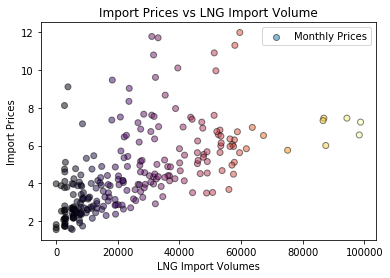

In [4]:
# Color Map
cmaps = OrderedDict()
# Data Splitting
y0 = data0['Import Prices']
x0 = data0['LNG Import Volume']
# Create scatter plot
plt.scatter(x0, y0, c=x0, cmap='inferno', edgecolor='black', linewidth=1, alpha=0.50, label="Monthly Prices")
# Format graph
plt.title("Import Prices vs LNG Import Volume")
plt.xlabel("LNG Import Volumes")
plt.ylabel("Import Prices")
plt.legend()
plt.show()

### Testing Correlation
- 1.0 < = Strong Correlation 
- 0.5 < = Some Correlation
- 0.5 > = Weak Correlation
- -0.5 > = Inverse Correlation

In [5]:
# Checking correlation
data0.corr()

,Import Prices,LNG Import Volume
Import Prices,1.00000,0.58927
LNG Import Volume,0.58927,1.00000


### Statistical Description of Data

In [6]:
# Statistical description of the dataset
data0.describe()

,Import Prices,LNG Import Volume
count,243.000000,243.000000
mean,4.542058,25351.255144
std,2.155483,20771.970437
min,1.540000,0.000000
25%,2.800000,7936.500000
50%,4.060000,20826.000000
75%,5.690000,36950.000000
max,11.990000,98742.000000


### Visualising the distribution of the data
The Data is obvouisly skewed from looking at the histogram. We can see both data sets are left skewed which tells me my correlation test was accurate. If my correlation test was -0.6 for example that would tell me the data is inversely correlated and the histogram would have a left skew and a right skew.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f1a907e10>,
      dtype=object)

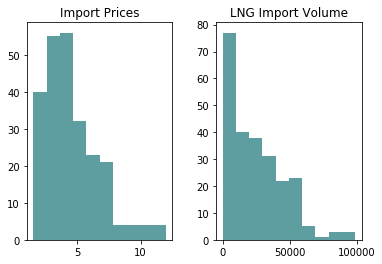

In [10]:
# Plotting distributions
data0.hist(grid=False,color='cadetblue')

### Proving the data is skewed and calculating residuals

In [11]:
# Calculate excess kurtosis using fisher method
x_kurtosis = kurtosis(x0, fisher=True)
y_kurtosis = kurtosis(y0, fisher=True)
# Calculate Skewness
x_skew = skew(x0)
y_skew = skew(y0)
# Calling
display("Import Prices Excess Kurtosis: {:.2}".format(x_kurtosis))
display("LNG Import Volume Excess Kurtosis: {:.2}".format(y_kurtosis))
display("Import Prices Skew: {:.2}".format(x_skew))
display("LNG Import Volume Skew: {:.2}".format(y_skew))     

'Import Prices Excess Kurtosis: 0.92'

'LNG Import Volume Excess Kurtosis: 1.2'

'Import Prices Skew: 1.1'

'LNG Import Volume Skew: 1.1'

### Testing Data

In [12]:
# Kurtosis Test
display('Import Prices')
display(stats.kurtosistest(x0))
display('LNG Import Volume')
display(stats.kurtosistest(y0))
# Skew Test
display('Import Prices')
display(stats.skewtest(x0))
display('LNG Import Volume')
display(stats.skewtest(y0))

'Import Prices'

KurtosistestResult(statistic=2.3936618873582605, pvalue=0.016681118129077268)

'LNG Import Volume'

KurtosistestResult(statistic=2.836202409008599, pvalue=0.0045653502410025115)

'Import Prices'

SkewtestResult(statistic=5.819142406743545, pvalue=5.915032394619643e-09)

'LNG Import Volume'

SkewtestResult(statistic=6.072114153262655, pvalue=1.2623714124476009e-09)

### Training data for linear regression

In [13]:
# Defining LNG Import Volume and dropping the column
Y0 = data0.drop('LNG Import Volume', axis = 1)
X0 = data0[['LNG Import Volume']]
# Split X0 and y0 into X0_
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.30, random_state=1)
# Rendering Linear Regression model
regression_model = LinearRegression()
# Passing X0_train & y0_train through the dataset.
regression_model.fit(X0_train, y0_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Calculating coefficient and intercept

In [14]:
# Grabbing and printing intercept and coefficient
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0] 
print("The Coefficient for our model is {:.2}".format(coefficient))
print("The intercept for our model is {:.4}".format(intercept))

The Coefficient for our model is 6.2e-05
The intercept for our model is 2.992


### Projecting future import prices

In [15]:
# Getting multiple predictions
y0_predict = regression_model.predict(X0_test)
# Show the first 5 predictions
y0_predict[:5]
# Defining input
X1 = sm.add_constant(X0)
# Render a OLS model.
model = sm.OLS(Y0, X1)
# Fitting Data
est = model.fit()

### Creating confidence intervals

In [16]:
# Setting Confidence Interval
est.conf_int()

,0,1
const,2.643509,3.340256
LNG Import Volume,0.000051,0.000072


### Calculating mean squared error, mean absolute error, and root mean squared error

In [17]:
# Calculating mean squared error
model_mse = mean_squared_error(y0_test, y0_predict)
# Calculating mean absolute error
model_mae = mean_absolute_error(y0_test, y0_predict)
# Calulcating troot mean squared error
model_rmse =  math.sqrt(model_mse)
# Printing Output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 2.88
MAE 1.28
RMSE 1.7


### Calculating r2

In [18]:
# Defining r2 and printing r2
model_r2 = r2_score(y0_test, y0_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.34


### Model Summary

In [19]:
# Printing Summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:          Import Prices   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     128.2
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           4.12e-24
Time:                        12:59:35   Log-Likelihood:                -479.10
No. Observations:                 243   AIC:                             962.2
Df Residuals:                     241   BIC:                             969.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.9919      0.17

### Residual Distribution

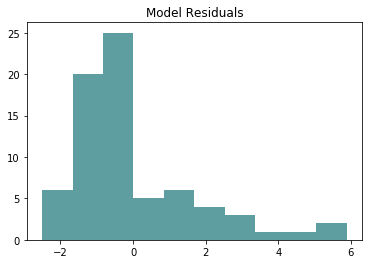

In [20]:
# Visualising Model Residuals via Hist. Distribution
(y0_test - y0_predict).hist(grid = False, color = 'cadetblue')
plt.title("Model Residuals")
plt.show()

# Linear regression Model:

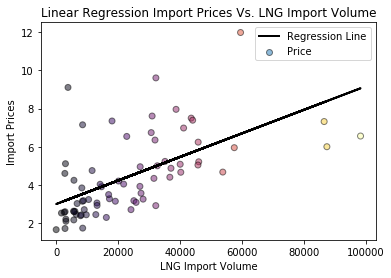

LNG Import Volume coefficient:6.2e-05
Mean squared error: 2.882
Root Mean squared error: 1.698
R2 score: 0.34


In [21]:
# Convert to array
X3_test = np.array(X0_test)
# Color Map
cmaps = OrderedDict()
# Plotting
plt.scatter(X3_test, y0_test,  c=X3_test, cmap='inferno', edgecolor='black', linewidth=1, alpha=0.50, label='Price')
plt.plot(X0_test, y0_predict, color='black', linewidth = 2, linestyle= '-',label ='Regression Line')
plt.title("Linear Regression Import Prices Vs. LNG Import Volume")
plt.xlabel("LNG Import Volume")
plt.ylabel("Import Prices")
plt.legend()
plt.show()
# Printing Coefficients
print('LNG Import Volume coefficient:' + '\033[1m' + '{:.2}''\033[0m'.format(regression_model.coef_[0][0]))
# Printing Mean squared error
print('Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(model_mse))
# Printing Mean squared error
print('Root Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(math.sqrt(model_mse)))
# Printing Variance score
print('R2 score: '+ '\033[1m' + '{:.2}''\033[0m'.format(r2_score(y0_test,y0_predict)))